In [55]:
import copy
import random
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [56]:
#求解Pn~Pm
QN = 3
QM = 0
#求解Rn~Rm
RN = 40

def generate_equidistant_array(min_val, max_val, m):
    if m <= 1:
        return [min_val] * m
    
    step = (max_val - min_val) / (m - 1)
    equidistant_array = [min_val + i * step for i in range(m)]
    
    return equidistant_array

# 定价空间计算
# 空间离散数量
m = 20
D_SPACE = generate_equidistant_array(0.01, 4, m)
# 罚款空间计算
# 空间离散数量
k = 15
PENALTY_SPACE = generate_equidistant_array(0, 1*(RN), k)
print(D_SPACE)
print(PENALTY_SPACE)

[0.01, 0.22000000000000003, 0.43000000000000005, 0.6400000000000001, 0.8500000000000001, 1.06, 1.2700000000000002, 1.4800000000000002, 1.6900000000000002, 1.9000000000000001, 2.11, 2.32, 2.5300000000000002, 2.74, 2.95, 3.16, 3.37, 3.58, 3.79, 4.0]
[0.0, 2.857142857142857, 5.714285714285714, 8.571428571428571, 11.428571428571429, 14.285714285714286, 17.142857142857142, 20.0, 22.857142857142858, 25.714285714285715, 28.571428571428573, 31.42857142857143, 34.285714285714285, 37.142857142857146, 40.0]


In [57]:
class Agent:
    def __init__(self, alpha=0.2, gamma=0.95, beta=0.00001, action_space = D_SPACE):
        """
        代理类，代表一个企业。
        参数:
            alpha (float): 学习率。
            beta (float): epsilon的消散比率
            gamma (float): 未来奖励的折扣因子。
            action_space (list): 定价空间
        """
        self.alpha = alpha
        self.gamma = gamma
        self.beta = beta
        self.action_space = action_space  # 策略空间
        self.q_matrix = {}      #用字典的形式存储Q-matrix
        for possible_quantity in itertools.product(D_SPACE, repeat=2):   
            for possible_penalty in PENALTY_SPACE:    #遍历笛卡尔积，即状态空间是双方的可能价格*罚金 m*m*k
                possible_state = (possible_quantity,possible_penalty)
                self.q_matrix[possible_state] = dict((quantity, 0.0) for quantity in action_space)       #每个定价（行动）的初始值为0

    def choose_action(self, state, t):
        """
        根据当前状态和时间步选择行动（价格）/选择是explore还是exploit
        参数:
            opponent_price (float): 对手的价格。
            t (int): 当前时间步。
        返回:
            float: 选择的价格。
        """
        epsilon = np.exp(-self.beta * t)
        if np.random.random() < epsilon:
            # explore：随机选择一个价格
            return np.random.choice(self.action_space)
        else:
            return self.get_optimal_action(state)
        
    def get_optimal_action(self,state):
        """
        根据Q-matrix和现在的state选择最优行动
        """
        optimal_actions = [
            action for action, value in self.q_matrix[state].items() if value == max(self.q_matrix[state].values())
            #获取最大qvalue对应的action，若有多个则随机选择
        ]
        return random.choice(optimal_actions)

    def update_q_table(self, state, action, reward, next_state):
        """
        更新Q表。
        参数:
            state (tuple): 双方上一期的价格。
            action (float): 本期的价格决策。
            reward (float): 本期的奖励。
            next_state (tuple): 本期结束双方的价格。
        """
        state_action_value = copy.deepcopy(self.q_matrix[state][action])
        future_next_state_action_value = self.q_matrix[next_state][self.get_optimal_action(next_state)]
        self.q_matrix[state][action] = (1 - self.alpha) * state_action_value + self.alpha * (
                                        reward + self.gamma * future_next_state_action_value)

In [58]:
class Regulator:
    def __init__(self, target, alpha=0.2, gamma=0.95, beta=0.00001, action_space = PENALTY_SPACE):
        """
        监管者类，在市场中对算法合谋行为进行自动监管
        参数:
            alpha (float): 学习率。
            beta (float): epsilon的消散比率
            gamma (float): 未来奖励的折扣因子。
            action_space (list): 罚款空间
        【将社会福利维持在给定水平target】:
            每周期观察到的收益为 (SW-target)^2
            决策目标为最小化 累积差值 ，也可写为 max 求和(-(SW-target)^2)
        """
        self.target = target
        self.alpha = alpha
        self.gamma = gamma
        self.beta = beta
        self.action_space = action_space  # 策略空间
        self.q_matrix = {}      #用字典的形式存储Q-matrix
        for possible_state in itertools.product(D_SPACE, repeat=2):       #遍历笛卡尔积，即状态空间是双方的可能价格 m*m
            self.q_matrix[possible_state] = dict((penalty, 0.0) for penalty in action_space)       #每个罚款（行动）的初始值为0

    def choose_action(self, state, t):
        """
        根据当前状态和时间步选择行动（价格）/选择是explore还是exploit
        参数:
            opponent_price (float): 对手的价格。
            t (int): 当前时间步。
        返回:
            float: 选择的价格。
        """
        epsilon = np.exp(-self.beta * t)
        if np.random.random() < epsilon:
            # explore：随机选择一个价格
            return np.random.choice(self.action_space)
        else:
            return self.get_optimal_action(state)
        
    def get_optimal_action(self,state):
        """
        根据Q-matrix和现在的state选择最优行动
        """
        optimal_actions = [
            action for action, value in self.q_matrix[state].items() if value == max(self.q_matrix[state].values())
            #获取最大qvalue对应的action，若有多个则随机选择
        ]
        return random.choice(optimal_actions)

    def update_q_table(self, state, action, walfare, next_state):
        """
        更新Q表。
        参数:
            state (tuple): 本期双方的价格决策。
            action (float): 监管者对合谋收取的罚金。
            reward (float): 本期中 -(SW-target)^2
            next_state (tuple): 下一期双方的定价决策。
        """
        reward = -((walfare-self.target) ** 2)
        state_action_value = copy.deepcopy(self.q_matrix[state][action])
        future_next_state_action_value = self.q_matrix[next_state][self.get_optimal_action(next_state)]
        self.q_matrix[state][action] = (1 - self.alpha) * state_action_value + self.alpha * (
                                        reward + self.gamma * future_next_state_action_value)

In [59]:
def calculate_price(quantities):
    """
    根据产量决策计算价格。
    参数:
    quantities (list): 所有公司的产量。
    返回:
    demands (list): 每个公司的需求列表。
    """
    return 120/(sum(quantities))

def calculate_profit(quantities, c=10, a=10):
    """
    计算每个公司的利润。
    参数:
    quantities (list): 所有公司的产量。
    返回:
    profits (list): 每个公司的利润列表。
    """  
    extra = [a]*len(quantities)
    price = calculate_price(quantities)
    profits = [(price - c) * x + y for x, y in zip(quantities, extra)]
    return profits

def consumer_surplus(quantities):
    """
    根据给定的反需求函数与均衡产量/价格，计算消费者剩余
    """
    # 均衡价格
    P_star = calculate_price(quantities)
    Q_star = sum(quantities)
    # 需求曲线积分（从 0 积分到 Q_star）
    cs_integral, _ = quad(lambda Q: (calculate_price([Q]) - P_star), 1e-8, Q_star)    # 在此处将Q转为一个iterable的list
    return cs_integral

def producer_surplus(quantities, c=10):
    """
    计算生产者剩余，用于计算社会福利
    """
    # 均衡价格
    P_star = calculate_price(quantities)
    Q_star = sum(quantities)
    # 生产者剩余（供给曲线与均衡价格的面积差）
    ps_integral = (P_star - c) * Q_star
    return ps_integral

def calculate_rewards_after_penalty(penalty,profits,penalty_mode = 1):
    """
    计算每个厂商被收取罚金之后的利润
    参数：
    penalty (float)：regulator输出的罚金，实际上为平均罚金
    profits (list)：每个厂商的原始利润
    mode (int)：罚金模式，mode为1时对各厂商收取等价罚金，mode为2时按照利润进行分配
    """
    if penalty_mode == 0:    # 不实际收取罚金
        rewards_after_penalty = profits
    elif penalty_mode == 1:    # 收取相等的罚金
        rewards_after_penalty = [x - penalty for x in profits]
    else:    # 按照超额利润的比例收取罚金
        new_list = [x - RN for x in profits]
        sum_list = sum(new_list)
        penalty_by_percentage = [(x / sum_list * penalty * len(new_list)) for x in new_list]
        rewards_after_penalty = [x - y for x, y in zip(profits, penalty_by_percentage)]
    return  rewards_after_penalty

In [60]:
class Market:
    def __init__(self, pricing_agents, regulator):
        self.agents = pricing_agents
        self.regulator = regulator
        print('厂商数量为：',len(self.agents))

    def simulation(self,penalty_mode=1,end_episode=1500000):
        # 初始化
        agents = self.agents
        regulator = self.regulator
        decesion_record = []
        penalty_record = []
        rewards_record = []
        walfare_record = []
        # 指定第一个周期的决策
        quantities = (D_SPACE[-1],D_SPACE[-1])
        penalty = PENALTY_SPACE[0]
        # 开始循环
        for episode in tqdm(range(end_episode)):
            new_quantities = [0,0]
            for i in range(len(agents)):
                agent_action = agents[i].choose_action((quantities,penalty),episode)
                new_quantities[i] = agent_action  # 决定产量
            new_quantities = tuple(new_quantities)

            # 计算销售利润
            profits = calculate_profit(new_quantities)
            # 计算本期的社会总福利
            CS = consumer_surplus(new_quantities)
            PS = producer_surplus(new_quantities)
            social_walfare = CS + PS
            
            # 消费者福利为上一期监管者的奖励，监管者进行学习
            regulator.update_q_table(quantities,  # 上期产量
                                     penalty,    # 上期收取的罚金
                                     social_walfare,    # 本期的消费者福利，是上一期的奖励
                                     new_quantities)    # 收取罚金后的决策
         
            # 收取罚金
            new_penalty = regulator.choose_action(new_quantities,episode)
            # 计算扣除罚金后的实际利润，0:不处罚，1:平分罚金/等额罚金，2:根据超额利润分配罚金
            rewards = calculate_rewards_after_penalty(new_penalty,profits,penalty_mode)
            
            # 定价代理进行学习
            for i in range(len(agents)):
                agents[i].update_q_table((quantities,penalty),   # 双方的产量，即状态
                                        new_quantities[i],  # 自己的产量决策
                                        rewards[i],
                                        (new_quantities,new_penalty))
                
            # 记录本周期的数据
            decesion_record.append(new_quantities)
            penalty_record.append(new_penalty)
            rewards_record.append(rewards)
            walfare_record.append([CS,PS])

            quantities = new_quantities
            penalty = new_penalty
            
        return decesion_record,rewards_record,penalty_record,walfare_record,

In [61]:
def calculate_and_plot_averages(data, plot_name, chunk_size = 1000):
    # 确定数据类型
    is_float = (isinstance(data[0], float) or isinstance(data[0], int))

    # 将数据转换为numpy数组
    if is_float:
        data_array = np.array(data)
    else:
        data_array = np.array(data, dtype=object)
    
    # 计算每1000个元素的平均值
    num_chunks = (len(data) + chunk_size - 1) // chunk_size  # 向上取整
    averages = []

    for i in range(num_chunks):
        chunk = data_array[i * chunk_size:(i + 1) * chunk_size]
        if is_float:
            avg = np.mean(chunk)
        else:
            avg = tuple(np.mean(chunk, axis=0))
        averages.append(avg)
    
    # 绘制折线图
    plt.figure(figsize=(10, 6))
    if is_float:
        plt.plot(averages, linestyle='-')
    else:
        for col in range(len(averages[0])):
            plt.plot([avg[col] for avg in averages], linestyle='-', label=f'Agent {col+1}')
        plt.legend()
        
    plt.ylabel('Average Values')
    plt.xlabel('Episodes (of 1000s)')
    plt.title(plot_name)
    plt.grid(True)
    plt.show()

def plot_avg_walfare(data):
    # 转换为 NumPy 数组便于处理
    data_array = np.array(data)

    # 分别提取 CS 和 PS
    CS_values = data_array[:, 0]
    PS_values = data_array[:, 1]

    # 计算新增列 SW = CS + PS
    SW_values = CS_values + PS_values

    # 每 1000 个周期计算一次平均值
    window_size = 1000
    num_windows = len(CS_values) // window_size

    # 计算每 1000 个周期的平均 CS、PS 和 SW
    CS_avg = [np.mean(CS_values[i*window_size:(i+1)*window_size]) for i in range(num_windows)]
    PS_avg = [np.mean(PS_values[i*window_size:(i+1)*window_size]) for i in range(num_windows)]
    SW_avg = [np.mean(SW_values[i*window_size:(i+1)*window_size]) for i in range(num_windows)]

    # 生成 x 轴对应的区间，表示每 1000 个周期为一组
    x_axis = np.arange(1, num_windows + 1) * 1000

    # 创建图形
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # 绘制 CS 和 SW 的折线图（左侧 y 轴）
    ax1.plot(x_axis, CS_avg, label='CS')
    ax1.plot(x_axis, SW_avg, label='SW')
    ax1.set_xlabel('Episodes (of 1000s)')
    ax1.set_ylabel('CS and SW')
    ax1.tick_params(axis='y')
    ax1.legend(loc='upper left')

    # 创建第二个 y 轴用于绘制 PS 的折线图（右侧 y 轴）
    ax2 = ax1.twinx()
    ax2.plot(x_axis, PS_avg, label='PS', color = 'green')
    ax2.set_ylabel('PS')
    ax2.tick_params(axis='y')
    ax2.legend(loc='upper right')

    # 添加图例和标签
    plt.title('Average Walfare')
    plt.legend()
    # 显示图像
    plt.show()

#### Target = 2300（远低于纳什均衡）
从大量次数的模拟结果中，我们发现，这种方法很难使社会总福利下降到2300的水平。实际上，到达2320似乎已经接近下限。

In [62]:
agent1 = Agent()
agent2 = Agent()
regulator = Regulator(target=2300)

market = Market([agent1,agent2],regulator)
decesion_record,rewards_record,penalty_record,walfare_record = market.simulation()

厂商数量为： 2


100%|██████████| 1500000/1500000 [05:49<00:00, 4297.66it/s]


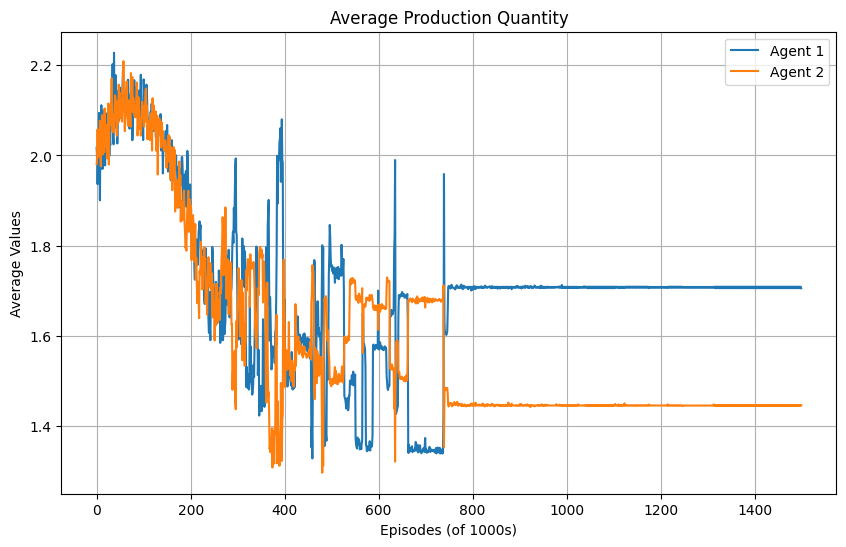

In [63]:
calculate_and_plot_averages(decesion_record,'Average Production Quantity')

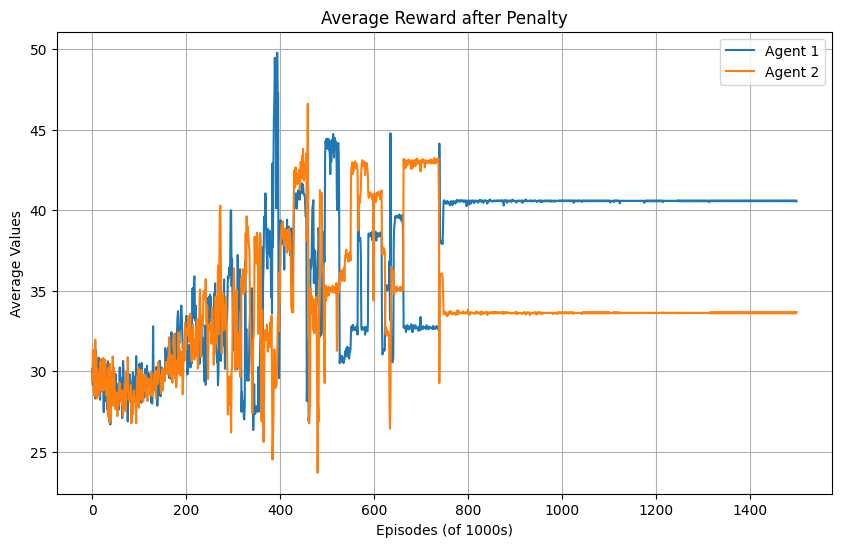

In [64]:
calculate_and_plot_averages(rewards_record,'Average Reward after Penalty')

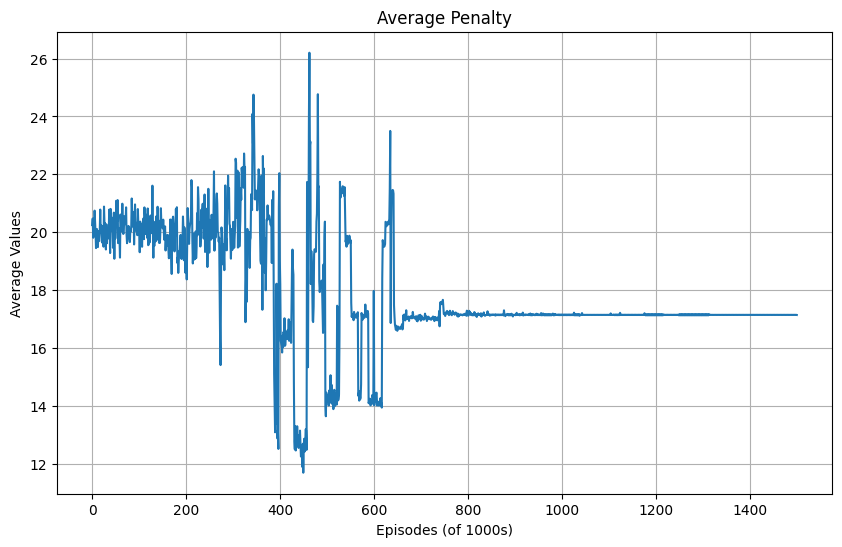

In [65]:
calculate_and_plot_averages(penalty_record,'Average Penalty')

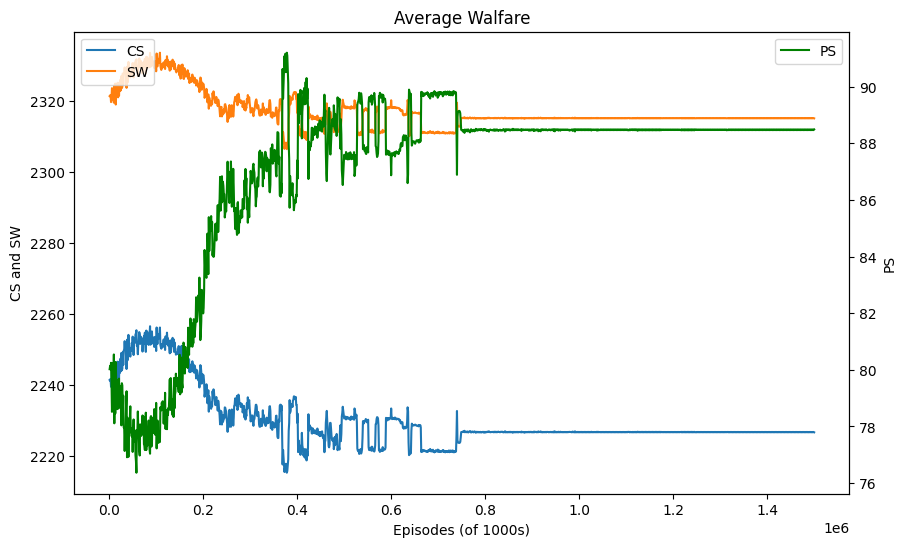

In [66]:
plot_avg_walfare(walfare_record)

#### Target = 2380 (高于纳什均衡)
同样的，要使社会福利大大超过纳什均衡（2360）的水平也是很难实现的，regulator可以引导社会福利接近或略高于无合谋情况下的福利，但是难以无上限地提高整体的社会福利。（也是符合直觉的）

In [67]:
agent1 = Agent()
agent2 = Agent()
regulator = Regulator(target=2380)

market = Market([agent1,agent2],regulator)
decesion_record,rewards_record,penalty_record,walfare_record = market.simulation()

厂商数量为： 2


100%|██████████| 1500000/1500000 [05:58<00:00, 4184.56it/s]


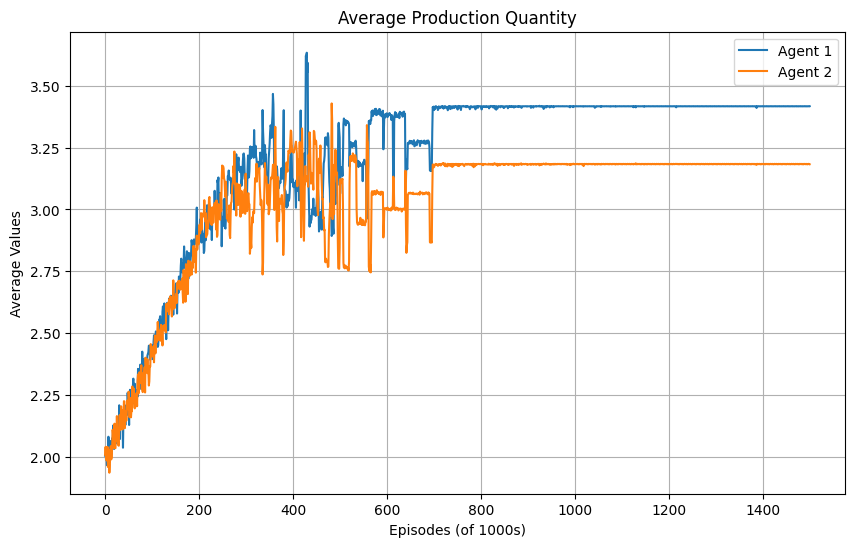

In [68]:
calculate_and_plot_averages(decesion_record,'Average Production Quantity')

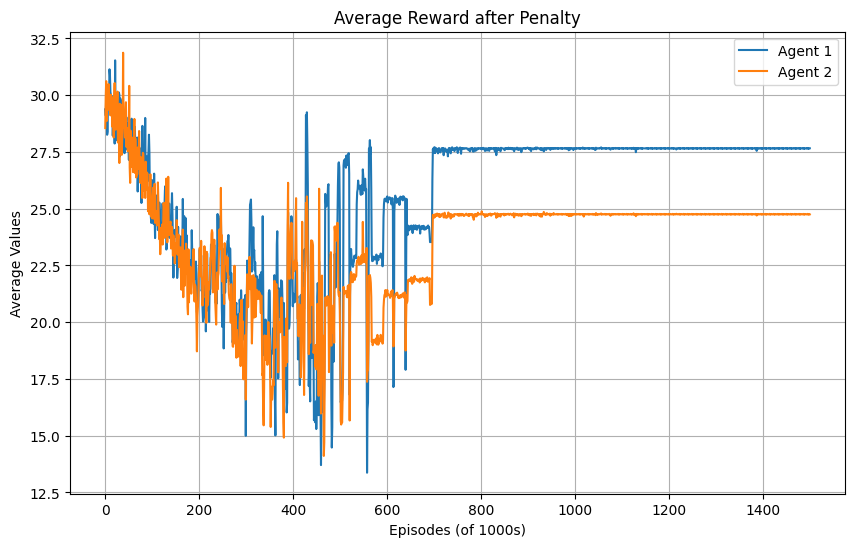

In [69]:
calculate_and_plot_averages(rewards_record,'Average Reward after Penalty')

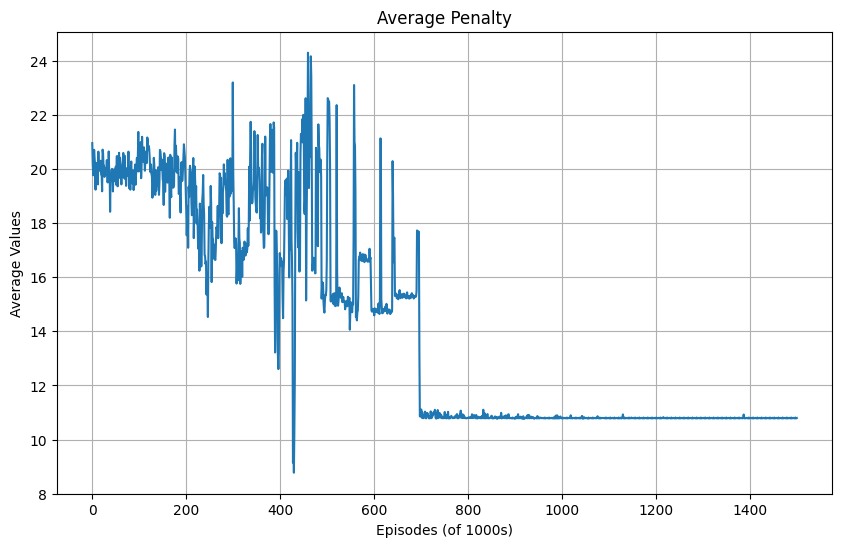

In [70]:
calculate_and_plot_averages(penalty_record,'Average Penalty')

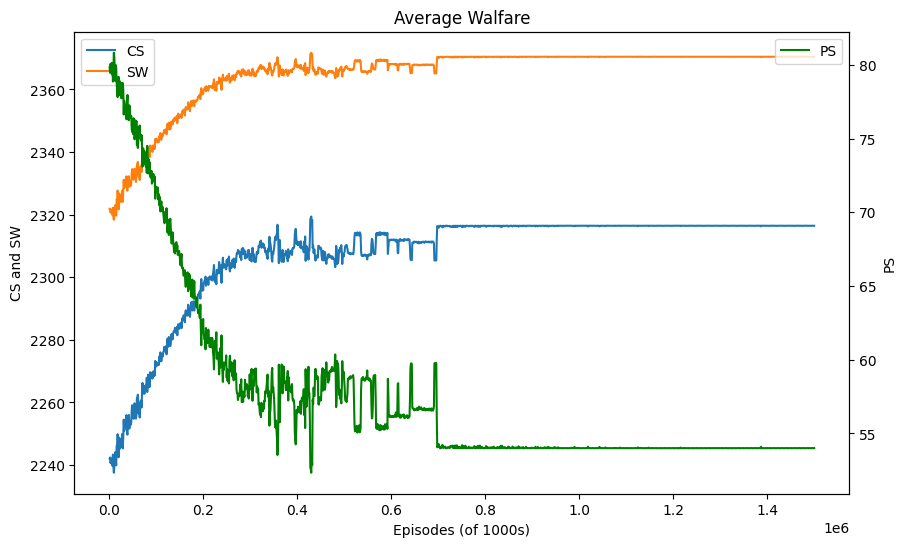

In [71]:
plot_avg_walfare(walfare_record)

#### Target = 2340（消费者福利与厂商利润均比较适中）

In [77]:
agent1 = Agent()
agent2 = Agent()
regulator = Regulator(target=2340)

market = Market([agent1,agent2],regulator)
decesion_record,rewards_record,penalty_record,walfare_record = market.simulation()

厂商数量为： 2


100%|██████████| 1500000/1500000 [05:58<00:00, 4181.54it/s]


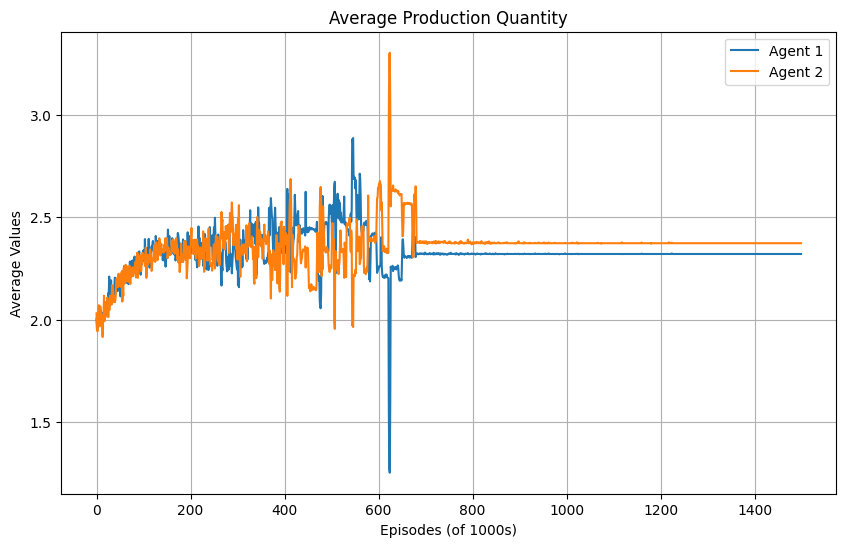

In [78]:
calculate_and_plot_averages(decesion_record,'Average Production Quantity')

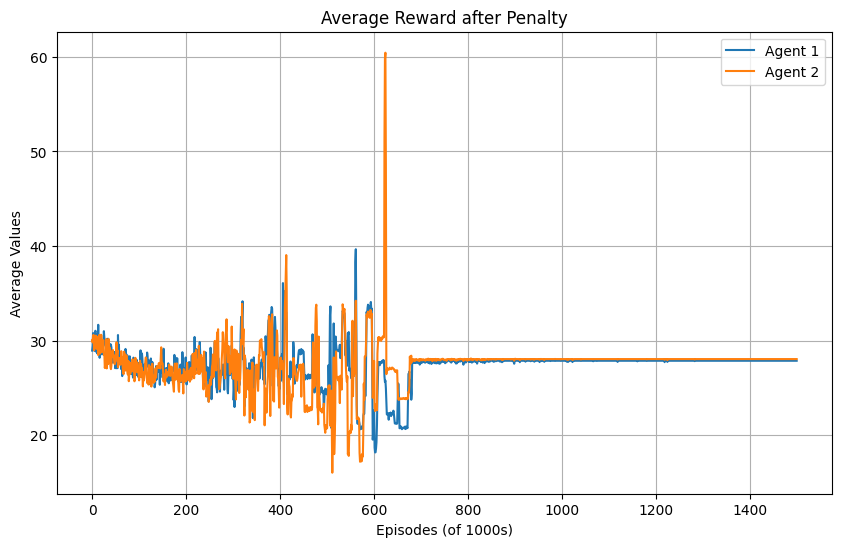

In [79]:
calculate_and_plot_averages(rewards_record,'Average Reward after Penalty')

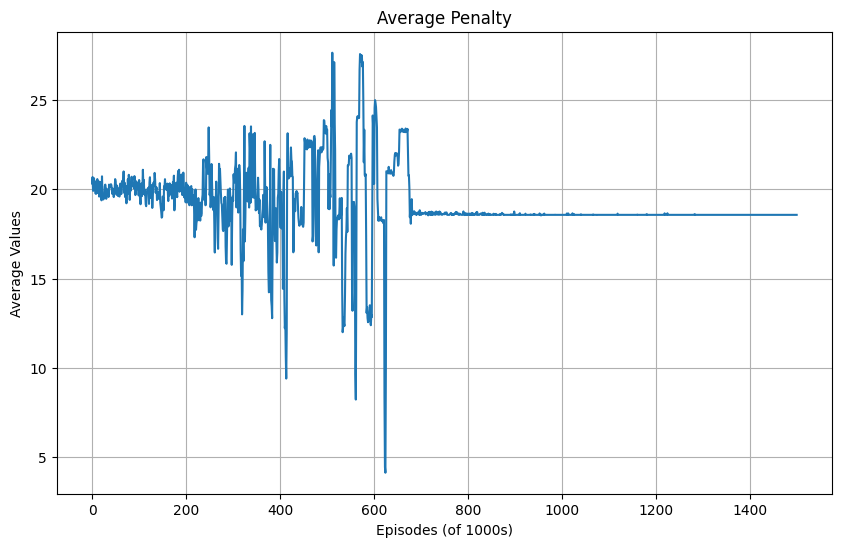

In [80]:
calculate_and_plot_averages(penalty_record,'Average Penalty')

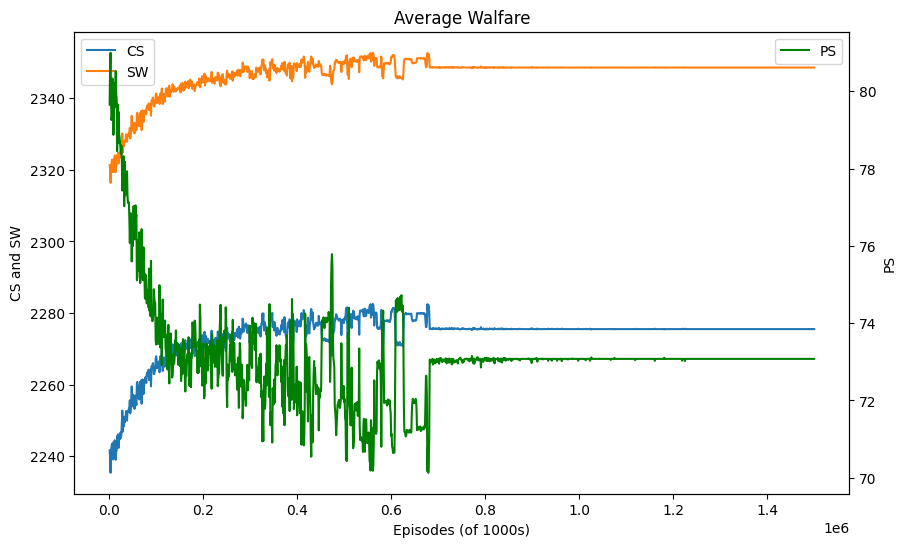

In [81]:
plot_avg_walfare(walfare_record)